In [1]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = 'Total_Any_Tobacco_7days'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=5000, latent_dim=100, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/{field}.pkl')

print('Done')

/home/anton/Documents/Tulane/Research/demo-vae/pip/src/demovae/sklearn.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load(path)


Done


In [10]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [11]:
# Load ADNI model

import pickle

adni = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/weightsBalanced3.pkl', 'rb'))
# adni = {'coef': None, 'intercept': 0}
# adni['coef'] = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/corrBalanced.pkl', 'rb'))


list(adni.keys())

['intercept', 'coef']

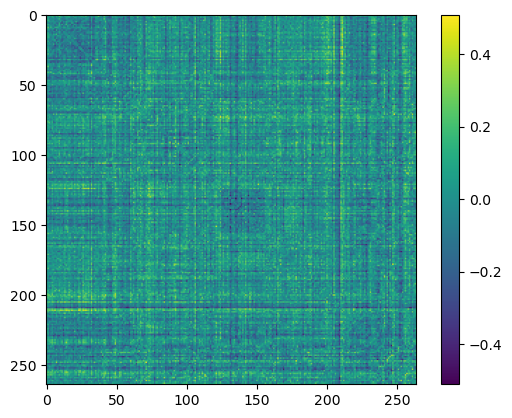

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

plt.imshow(vec2mat(adni['coef']))
plt.colorbar()
plt.show()

In [13]:
dct['demos'][4][:20]

array([ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.])

In [25]:
import numpy as np

vals = []
synth_mean = np.zeros(34716)

for i in range(20):
    synth = vae.transform(len(dct['demos'][0]), dct['demos'], dct['types'])
    synth_mean += np.mean(synth, axis=0)/20
    
    b = adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in synth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(synth))

print(np.mean(vals))
print(np.std(vals))

-60.99301745062261
0.7964952060670129


In [26]:
# Height and AD https://pmc.ncbi.nlm.nih.gov/articles/PMC6037293/
# Observational studies have linked increased adult height with better cognitive performance and reduced 
# risk of Alzheimer’s disease (AD). It is unclear whether the associations are due to shared biological 
# processes that influence height and AD or due to confounding by early life exposures or environmental factors.

vals = []
nsynth_mean = np.zeros(34716)

for i in range(20):
    ndemo = []
    for d in dct['demos']:
        dd = d+0
        ndemo.append(dd)

    # ndemo[4] = 0*np.ones(len(ndemo[1]))
    ndemo[4] -= 15
    
    nsynth = vae.transform(len(dct['demos'][0]), ndemo, dct['types'])
    nsynth_mean += np.mean(nsynth, axis=0)/20
    
    sum_logits = 0
    
    for fc in nsynth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(nsynth))

print(np.mean(vals))
print(np.std(vals))

-75.52280763583063
1.2018386562863346


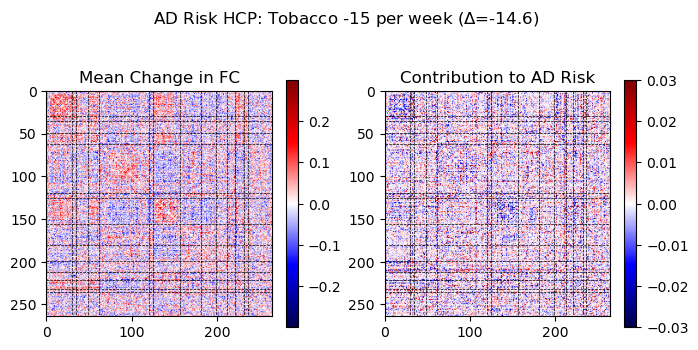

In [27]:
# Make two graphs: one mean change in FC, the other mean change in AD risk
# Use seismic or RdBu colormaps

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1,2,figsize=(8,4))

subject = 'HCP: Tobacco -15 per week'
delta = '-14.6'
diff = nsynth_mean-synth_mean
diffw = w*diff
tit = subject.replace(' ', '_')

norm1 = TwoSlopeNorm(vmax=0.3, vmin=-0.3, vcenter=0)
norm2 = TwoSlopeNorm(vmax=0.03, vmin=-0.03, vcenter=0)

pos = ax[0].imshow(vec2mat(diff), norm=norm1, cmap='seismic')
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(vec2mat(diffw), norm=norm2, cmap='seismic')
fig.colorbar(pos, ax=ax[1], shrink=0.8)

for i in range(len(divis)-1):
    d = divis[i+1]
    ax[0].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[0].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')

ax[0].set_xlim([0,264])
ax[0].set_ylim([264,0])
ax[1].set_xlim([0,264])
ax[1].set_ylim([264,0])

ax[0].set_title('Mean Change in FC')
ax[1].set_title('Contribution to AD Risk')

fig.suptitle(f'AD Risk {subject} ($\\Delta$={delta})')
fig.show()
# fig.savefig(f'/home/anton/Documents/Yale/HCP/Figures/FCChanges2/{tit}.pdf')

In [28]:
# Individual ROIs

a,b = np.triu_indices(264,1)
top = np.argsort(np.abs(diffw))[::-1]
num = 8

print(tit, delta)
print('Individual ROIs')
for i in range(num):
    r1 = a[top[i]]
    r2 = b[top[i]]
    print(top[i], r1, r2, getlabel(r1), getlabel(r2), diffw[top[i]])

vals = []
sums = []
labs = []
W = vec2mat(diffw)
net_sums = [0]*14
net_means = [0]*14

for i in range(len(divis)-1):
    for j in range(len(divis)-1):
        r1a = divis[i]
        r1b = divis[i+1]
        r2a = divis[j]
        r2b = divis[j+1]
        WW = W[r1a:r1b,r2a:r2b]
        net_sums[i] += np.sum(WW)
        net_means[i] += np.mean(WW)
        if j >= i:
            val = np.mean(WW)
            vals.append(val)
            val = np.sum(WW)
            sums.append(val)
            labs.append(f'{labels[i]}-{labels[j]}')

idcs = np.argsort(np.abs(vals))[::-1]

print('Networks Mean')
for i in range(num):
    print(vals[idcs[i]], labs[idcs[i]])

idcs = np.argsort(np.abs(sums))[::-1]

print('Networks Sum')
for i in range(num):
    print(sums[idcs[i]], labs[idcs[i]])

print('Agg Sum')
for s in net_sums:
    print(s)

print('Agg Avg')
for a in net_means:
    print(a)

HCP:_Tobacco_-15_per_week -14.6
Individual ROIs
33843 221 252 DRSL UNK -0.07227016823450681
20531 95 107 DMN DMN -0.07223401360223562
26590 136 139 VIS VIS -0.06717009441754904
7548 30 124 SMTM MEM -0.06408766244223991
14846 64 95 DMN DMN -0.06229805565015502
4207 16 136 SMTH VIS -0.05687863043977711
7928 32 41 SMTM CNG 0.05407127324758769
14479 62 127 DMN VIS 0.053497170512875405
Networks Mean
-0.006321266786826495 SMTM-SMTM
-0.005916160549044345 SMTM-MEM
0.005050583308385064 MEM-MEM
-0.004101450989769842 CBL-CBL
-0.003632741154344152 VIS-VIS
0.003486645766402518 SMTM-CBL
-0.0032393889163711558 SMTH-SMTM
-0.0030713278972705964 AUD-DRSL
Networks Sum
-3.4910642493247304 VIS-VIS
-2.5314352476718973 SMTH-SMTH
-1.4412821363005932 DMN-DMN
-1.1125137828395286 SMTH-VIS
-0.9508884991747797 VIS-DRSL
-0.8826109602328404 SMTH-SUB
-0.8824697521711979 SMTH-DMN
-0.8722517443789295 SMTH-DRSL
Agg Sum
-7.745159555232332
-1.2983087648964065
-0.5302307628365057
-2.4653522658635607
-2.638829564018039
-0.4

In [177]:
np.sum(sums)

np.float64(0.32671763258463776)